## Part 1: Data Preparation and Exploration

### Data Loading

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

df = pd.read_csv('C:\\Users\\hp\\Downloads\\Timeseries\\exchange_rate.csv',index_col='date', parse_dates=True)
df.index.freq = 'D'

In [31]:
df.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [32]:
df.tail()

,Ex_rate
date,
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197
09-10-2010 00:00,0.720825
10-10-2010 00:00,0.720825


### Initial Exploration

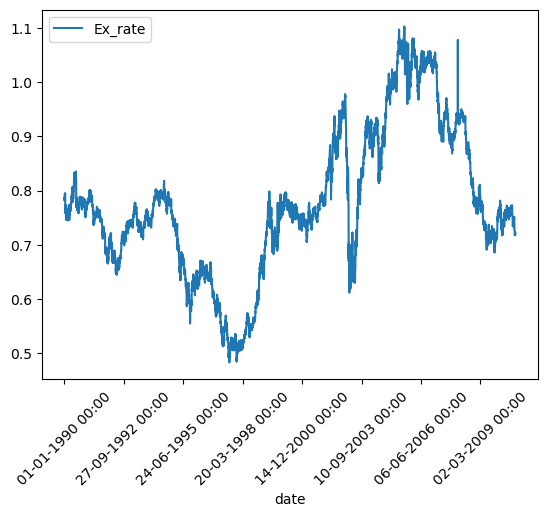

In [33]:
ax = df.plot()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

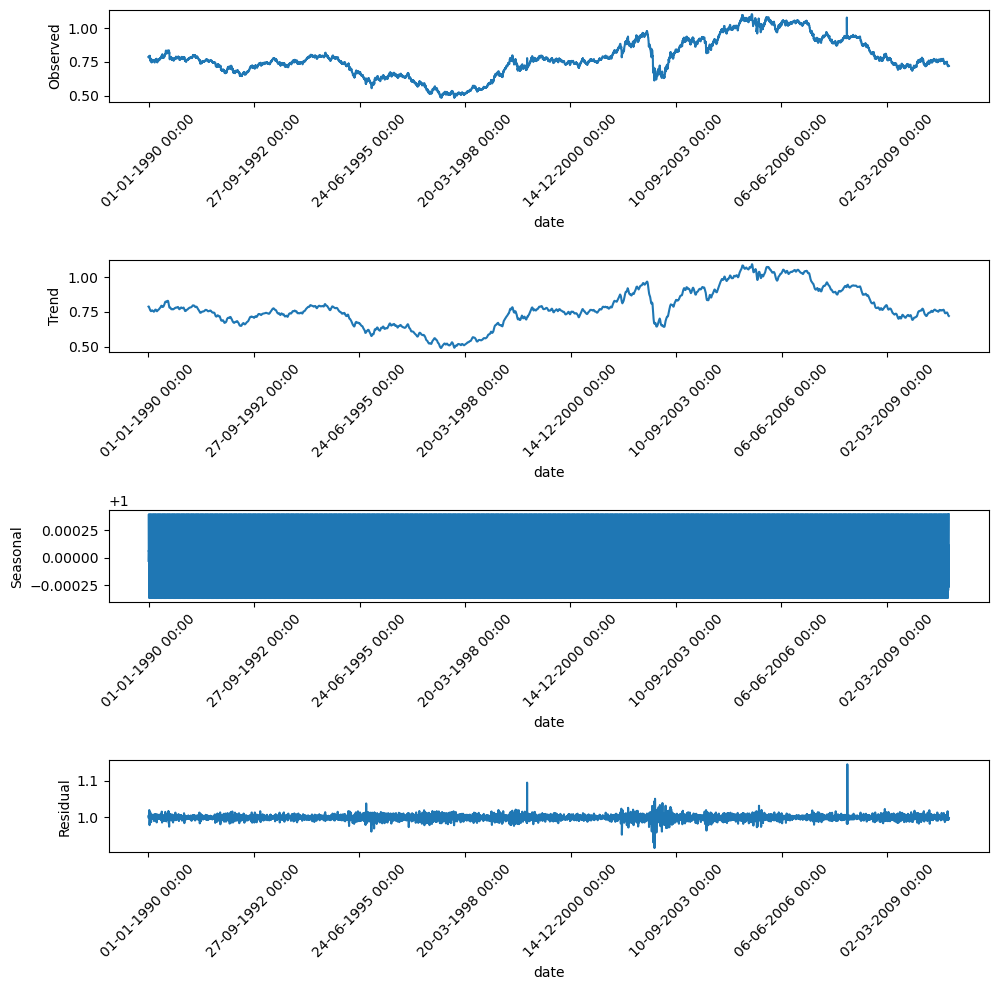

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Ex_rate'], model='multiplicative', period=12) 

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

result.observed.plot(ax=axs[0])
axs[0].set_ylabel('Observed')

result.trend.plot(ax=axs[1])
axs[1].set_ylabel('Trend')

result.seasonal.plot(ax=axs[2])
axs[2].set_ylabel('Seasonal')

result.resid.plot(ax=axs[3])
axs[3].set_ylabel('Residual')

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
plt.tight_layout()
plt.show()


### Data Preprocessing

In [35]:
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

In [36]:
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [37]:
df.shape

(7588, 1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [39]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


#### This shows no missing values in the dataset.

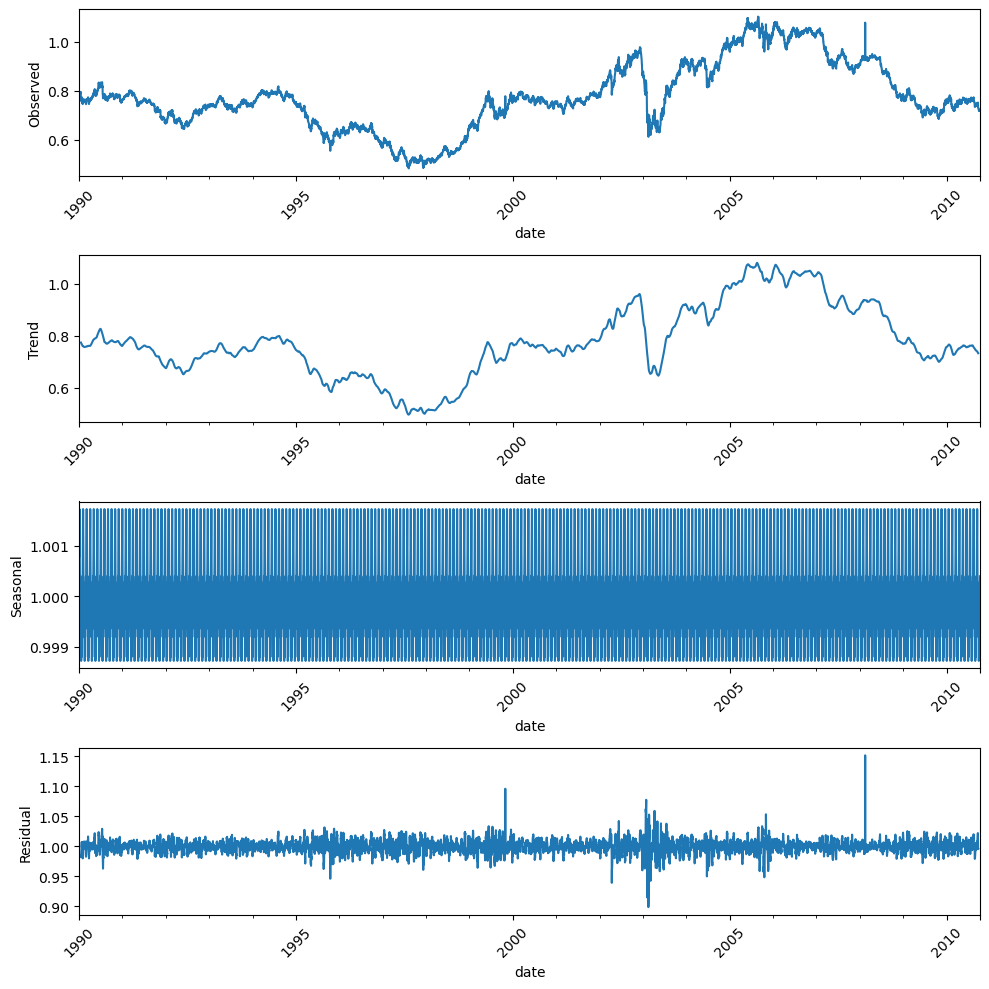

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Ex_rate'], model='multiplicative', period=30) 

fig, axs = plt.subplots(4, 1, figsize=(10, 10))

result.observed.plot(ax=axs[0])
axs[0].set_ylabel('Observed')

result.trend.plot(ax=axs[1])
axs[1].set_ylabel('Trend')

result.seasonal.plot(ax=axs[2])
axs[2].set_ylabel('Seasonal')

result.resid.plot(ax=axs[3])
axs[3].set_ylabel('Residual')

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
plt.tight_layout()
plt.show()


## Part 2: Model Building - ARIMA

### Parameter Selection for ARIMA

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

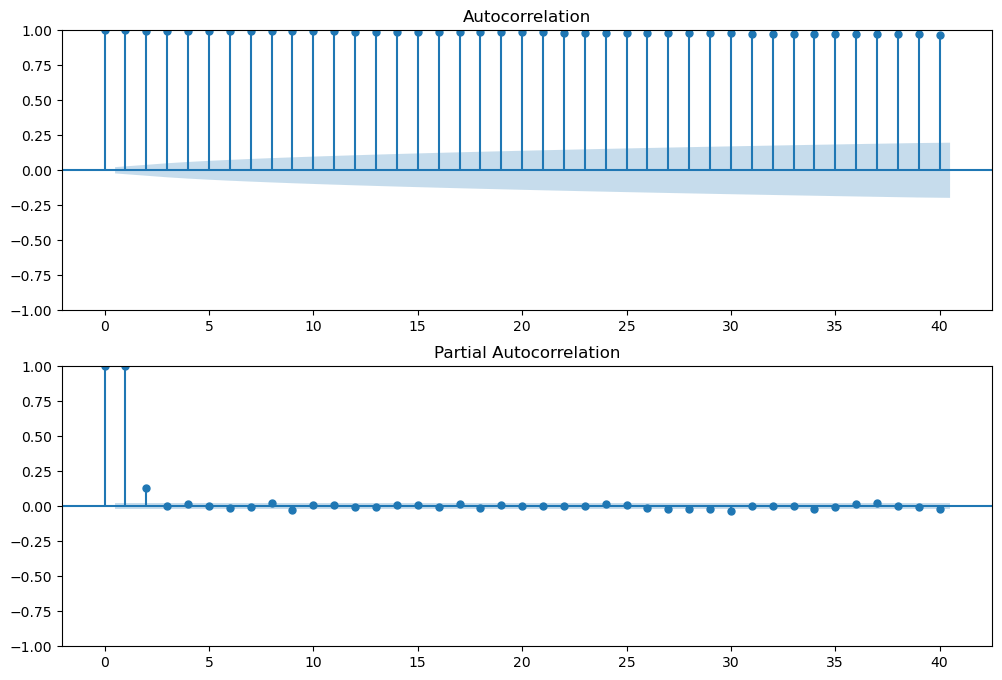

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['Ex_rate'], lags=40, ax=ax1)
plot_pacf(df['Ex_rate'], lags=40, ax=ax2);


#### Stationary or not (Augmented Dickey-Fuller Test)

In [43]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [44]:
print('Augmented Dickey-Fuller Test on Exchange rates')
dftest = adfuller(df['Ex_rate'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Exchange rates


(-1.6649941807381343,
 0.44923273535979974,
 1,
 7586,
 {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108},
 -55835.06254628545)

In [45]:
print('Augmented Dickey-Fuller Test on Exchange rates')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Exchange rates
ADF test statistic        -1.664994
p-value                    0.449233
# lags used                1.000000
# observations          7586.000000
critical value (1%)       -3.431212
critical value (5%)       -2.861921
critical value (10%)      -2.566973
dtype: float64


Here we have a very high p-value at 0.44, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.<br>


In [46]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Ex_rate'],k_diff=1)
adf_test(df['d1'],'Exchange Rates')

Augmented Dickey-Fuller Test: Exchange Rates
ADF test statistic       -99.393431
p-value                    0.000000
# lags used                0.000000
# observations          7586.000000
critical value (1%)       -3.431212
critical value (5%)       -2.861921
critical value (10%)      -2.566973
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Here we have a very high p-value at 0.00, which provides weak evidence against the null hypothesis, and so we <em>fail to accept</em> the null hypothesis, and decide that our dataset is stationary.<br>

<i> Parameters p,d,q are (1,1,0) as observed. </i>

### Model Fitting

In [47]:
from statsmodels.tsa.arima.model import ARIMA

In [48]:
train = df.iloc[:-365]
test = df.iloc[365:]

In [49]:
# Fit the ARIMA(1,1,0) model
model = ARIMA(train['Ex_rate'], order=(1,1,0))
results = model.fit()

# Print model summary
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7223
Model:                 ARIMA(1, 1, 0)   Log Likelihood               26630.924
Date:                Mon, 03 Jun 2024   AIC                         -53257.848
Time:                        10:35:14   BIC                         -53244.078
Sample:                    01-01-1990   HQIC                        -53253.110
                         - 10-10-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1324      0.002    -63.577      0.000      -0.136      -0.128
sigma2       3.67e-05   1.04e-07    354.247      0.000    3.65e-05    3.69e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

### Diagnostics

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

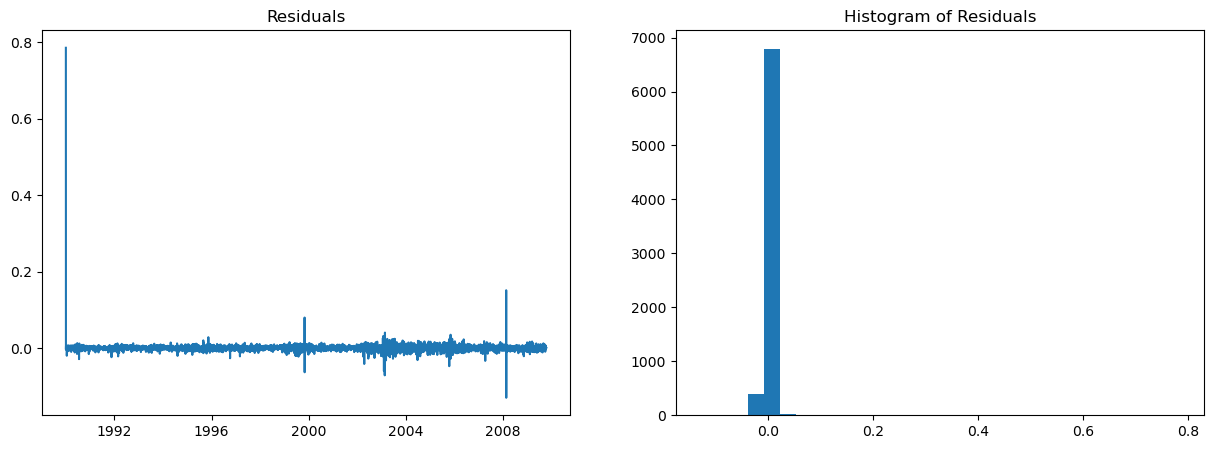

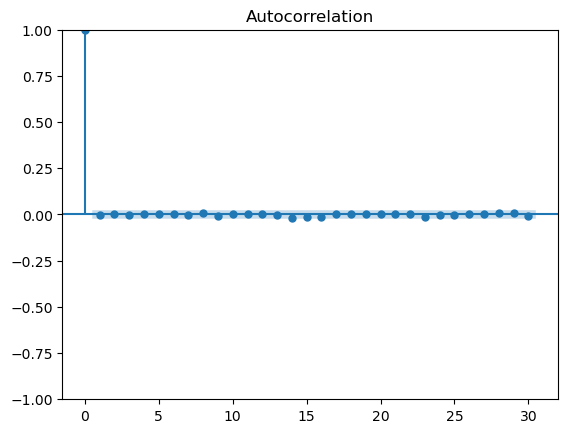

Ljung-Box test results:
     lb_stat  lb_pvalue
10  1.618443   0.998517
15  5.507108   0.986893
20  6.712714   0.997526


In [51]:
# Residuals diagnostics
residuals = results.resid

# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogram of Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30)
plt.show()

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)
print("Ljung-Box test results:")
print(lb_test)

### Forecasting

In [52]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Predictions')
print(predictions)

2009-10-11    0.728467
2009-10-12    0.728470
2009-10-13    0.728469
2009-10-14    0.728469
2009-10-15    0.728469
                ...   
2029-07-16    0.728469
2029-07-17    0.728469
2029-07-18    0.728469
2029-07-19    0.728469
2029-07-20    0.728469
Freq: D, Name: ARIMA(1,1,0) Predictions, Length: 7223, dtype: float64


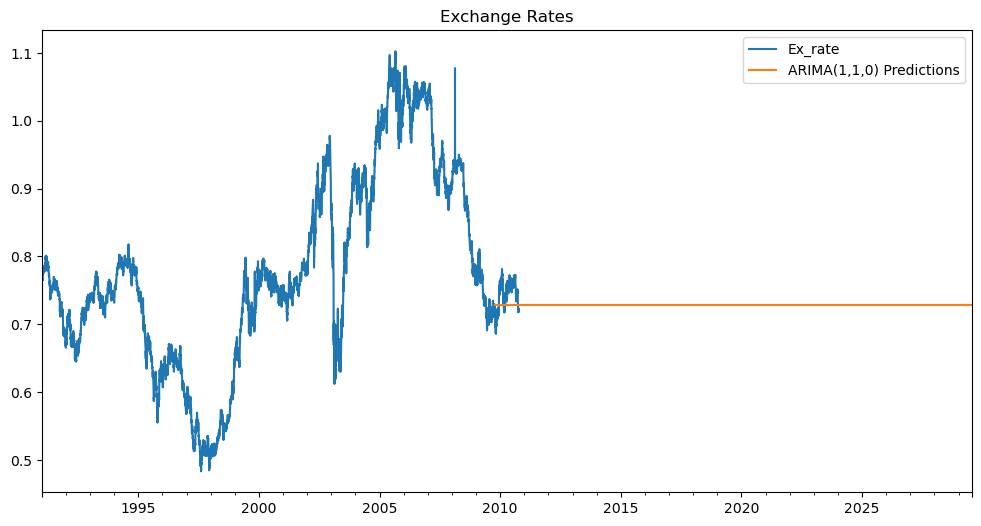

In [53]:
title = 'Exchange Rates'
ylabel = ''
xlabel = ''
ax = test['Ex_rate'].plot(legend=True, figsize=(12, 6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

## Part 3: Model Building - Exponential Smoothing

As we have already observed with the help of seasonal decomposition there is no clear trend or seasonality, we are going to choose Simple Exponential Smoothing (SES)

### Parameter Optimization

In [54]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [55]:
alpha_values = np.linspace(0.01, 0.99, 100)

best_model = None
best_aic = float('inf')

for alpha in alpha_values:
    model = SimpleExpSmoothing(df['Ex_rate'])
    fit = model.fit(smoothing_level=alpha)
    aic = fit.aic
    if aic < best_aic:
        best_model = fit
        best_aic = aic

print(f"Best Alpha: {best_model.model.params['smoothing_level']}")
print(f"Best AIC: {best_aic}")

Best Alpha: 0.8712121212121212
Best AIC: -77644.9704404787


### Model Fitting and Forecasting

2010-10-11    0.720861
2010-10-12    0.720861
2010-10-13    0.720861
2010-10-14    0.720861
2010-10-15    0.720861
                ...   
2011-10-06    0.720861
2011-10-07    0.720861
2011-10-08    0.720861
2011-10-09    0.720861
2011-10-10    0.720861
Freq: D, Length: 365, dtype: float64


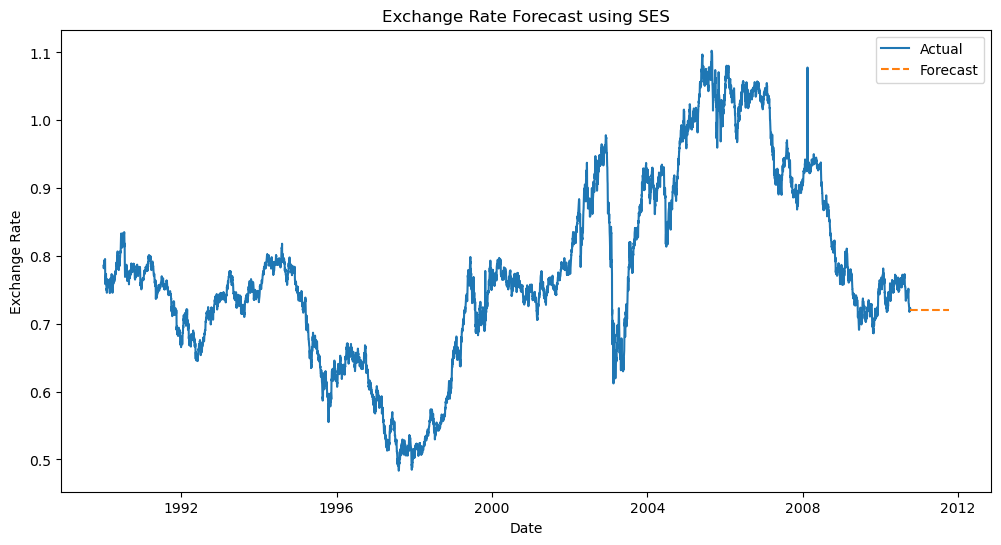

In [56]:
model = SimpleExpSmoothing(df['Ex_rate'])
fit = model.fit(smoothing_level=0.8712)

# Forecast future values
forecast = fit.forecast(steps=365)
print(forecast)

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Exchange Rate Forecast using SES')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show();

## Part 4: Evaluation and Comparison

### Compute Error Metrics

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute forecasts for ARIMA (1,1,0) model
start_idx = len(train)  # Index where test data starts
end_idx = start_idx + len(test) - 1  # Index where test data ends
arima_forecast = results.predict(start=start_idx, end=end_idx)

# Compute error metrics for ARIMA model
arima_mae = mean_absolute_error(test['Ex_rate'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], arima_forecast))
arima_mape = np.mean(np.abs((test['Ex_rate'] - arima_forecast) / test['Ex_rate'])) * 100

# Compute forecasts for SES model
start_idx = len(train)  # Index where test data starts
end_idx = start_idx + len(test) - 1  # Index where test data ends
ses_forecast = fit.predict(start=start_idx, end=end_idx)


# Compute error metrics for SES model
ses_mae = mean_absolute_error(test['Ex_rate'], ses_forecast)
ses_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], ses_forecast))
ses_mape = np.mean(np.abs((test['Ex_rate'] - ses_forecast) / test['Ex_rate'])) * 100

# Print error metrics
print("ARIMA (1,1,0) Model:")
print(f"MAE: {arima_mae}")
print(f"RMSE: {arima_rmse}")
print(f"MAPE: {arima_mape}\n")

print("SES Model:")
print(f"MAE: {ses_mae}")
print(f"RMSE: {ses_rmse}")
print(f"MAPE: {ses_mape}")


ARIMA (1,1,0) Model:
MAE: 0.11222495202991488
RMSE: 0.14808061434071815
MAPE: 3.122351464488248

SES Model:
MAE: 0.11454201013262125
RMSE: 0.15070941154434916
MAPE: 0.43163492763695


### Model Comparison

<h4><b>Performance Comparison:</b></h4>
* Both models have similar MAE and RMSE values, indicating similar overall accuracy.
* The SES model has a lower MAPE value, suggesting that it might be slightly better at predicting the percentage error.
* However, the differences in error metrics between the two models are relatively small, indicating that their performance is comparable.

<h4><b>Advantages and Limitations:</b></h4>
<b>ARIMA Model:</b>

* Advantages: ARIMA models can capture complex temporal structures in the data, such as trends and seasonality. They are also generally robust and can handle a wide range of time series patterns.
* Limitations: ARIMA models require stationary data, which might require additional preprocessing steps. They also assume linear relationships, which may not always hold in practice.

<b>SES Model:</b>

* Advantages: SES is simple and computationally efficient, making it easy to implement and interpret. It can also adapt well to changing data patterns over time.
* Limitations: SES is less flexible than ARIMA and may not capture complex time series patterns as effectively. It also requires the selection of a smoothing parameter (alpha), which can impact its performance.

### Conclusion

* In this case, both models perform similarly in terms of accuracy, with the SES model slightly outperforming the ARIMA model in terms of MAPE.
* The choice between these models would depend on the specific characteristics of the data and the trade-offs between model complexity and interpretability. For simpler time series with no complex patterns, SES might be preferred, while for more complex time series with trends and seasonality, ARIMA could be more suitable.